In [1]:
import time
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#### Dataset
Truncated version of http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz

The full dataset contains about 1.6M reviews of electronic products on amazon.com. This particular dataset is a truncated version which includes 100,000 of those reviews.

In [2]:
prod_reviews = pd.read_json('datasets/elecs_reviews_amzn.json', 
                            lines = True)

prod_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [3]:
prod_reviews.shape

(100000, 9)

#### Examine the first review
A 5-star rating for a GPS (the reviews are from the mid 2000s)

In [4]:
prod_reviews['overall'][0]

5

In [5]:
prod_reviews['reviewText'][0]

'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

#### Create 2 classes for the reviews
5-star reviews are tagged "positive", represented with a zero. 1 and 2 stars earn a "negative" tag represented with a 1. Given there are many more positive than negative reviews, assigning 1 to negative reviews helps us calculate precision

In [6]:
prod_reviews.loc[prod_reviews.overall > 4, 'tag'] = 0

In [7]:
prod_reviews.loc[prod_reviews.overall < 3, 'tag'] = 1

In [8]:
prod_reviews = prod_reviews[['reviewText', 'tag']]

prod_reviews.head()

,reviewText,tag
0,We got this GPS for my husband who is an (OTR)...,0.0
1,"I'm a professional OTR truck driver, and I bou...",1.0
2,"Well, what can I say. I've had this unit in m...",NaN
3,"Not going to write a long review, even thought...",1.0
4,I've had mine for a year and here's what we go...,1.0


#### Drop the 3 and 4-star reviews

In [9]:
prod_reviews.dropna(inplace=True)

prod_reviews.shape

(71613, 2)

In [10]:
prod_reviews.groupby(by='tag').count()

,reviewText
tag,
0.0,60287
1.0,11326


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [12]:
prod_reviews['tag'] = label_encoder.fit_transform(prod_reviews['tag'])

prod_reviews.sample(10)

,reviewText,tag
499,Let just start off by saying that I have tried...,0
63235,I'm not usually one to write reviews on Amazon...,0
5387,"Works great, nice to have the printer away fro...",0
10717,I am quite pleased with Canon STE2 transmitter...,0
83235,"Plug one end into your lcd, and the other end ...",0
82462,I received my pair of JVC HANC100's today from...,1
67131,I always buy Hoya. They are Amazing. The sam...,0
52978,"Hi,I purchased this drive and am very happy ab...",0
71057,Although Canon products can be pricey - they d...,0
88333,According to both Linksys and AOL this router ...,1


In [13]:
prod_reviews.groupby(by='tag').count()

,reviewText
tag,
0,60287
1,11326


#### Initialize a HashingVectorizer
We use a HashingVectorizer to ensure that the number of features for the text data is constant. This is required as the out-of-core learning means that we will be performing training multiple times and the number of features should be the same irrespective of the corpus

In [14]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=2 ** 18,
                               alternate_sign=False)

#### Initialize the SGDClassifier
This is one of the classifiers which includes the partial_fit method for out-of-core learning

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(prod_reviews['reviewText'], 
                                                    prod_reviews['tag'], 
                                                    test_size=0.2)

In [17]:
print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (57290,)
Shape of y_train:  (57290,)
Shape of x_test:  (14323,)
Shape of y_test:  (14323,)


In [18]:
x_test = vectorizer.transform(x_test)

In [19]:
batch_size = 500

classes = prod_reviews['tag'].unique()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### A function to train a classifier in batches
This function will be fed:
* an initialized classifier
* the training data
* the batch size to use for training
* the classes for classifier (required for the partial_fit method)

The training data will be broken up into batches. For each batch, this function will:
* transform the features in the batch using the HashingVectorizer
* run a partial_fit on the data using the classifier

After breaking from the while loop, there will be some samples which are yet to be used for training as their number is less than the batch size. We run partial_fit one final time for this data

In [22]:
def train_classifier(clf, x_train, y_train, batch_size, classes):
    
    
    vectorizing_latencies = []
    training_latencies = []
    prediction_latencies = []
    prediction_accuracies = []
    
    i = 1
    start = 0
    end = batch_size
    
    while (end < x_train.shape[0]):
    
        start_time = time.time()
        x_batch = vectorizer.transform(x_train[start:end])
        
        vectorizing_latencies.append(time.time() - start_time)
        
        y_batch = y_train[start:end]

        start_time = time.time()
        clf.partial_fit(x_batch, 
                        y_batch, 
                        classes=classes)

        training_latencies.append(time.time() - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(x_test)

        prediction_latencies.append(time.time() - start_time)

        prediction_accuracies.append(accuracy_score(y_test, y_pred))
        
        start += batch_size
        end += batch_size
        i += 1
        
    end = x_train.shape[0]
    
    x_batch = vectorizer.transform(x_train[start:end])
    y_batch = y_train[start:end]
    
    clf.partial_fit(x_batch, 
                    y_batch, 
                    classes=classes)
    
    return {'classifier': clf, 
            'vectorizing_latencies': vectorizing_latencies,
            'training_latencies' : training_latencies,
            'prediction_latencies': prediction_latencies, 
            'prediction_accuracies': prediction_accuracies}

#### Train the SGD classifier

In [23]:
sgd_training_details = train_classifier (sgd_clf, 
                                         x_train, 
                                         y_train, 
                                         batch_size, 
                                         classes)

In [24]:
def convert_to_dataframe(ooc_training_details):
    ooc_training_details_df = pd.DataFrame()

    for key in ooc_training_details:
        if key != 'classifier':
            ooc_training_details_df[key] = ooc_training_details[key]
    
    return ooc_training_details_df

In [25]:
sgd_training_details_df = convert_to_dataframe(sgd_training_details)

sgd_training_details_df

,vectorizing_latencies,training_latencies,prediction_latencies,prediction_accuracies
0,0.059468,0.002338,0.004680,0.847727
1,0.048564,0.002032,0.005313,0.853522
2,0.049409,0.002010,0.005322,0.850171
3,0.053524,0.002106,0.004961,0.854709
4,0.039199,0.001443,0.003473,0.859736
...,...,...,...,...
109,0.040487,0.001501,0.004116,0.895553
110,0.041341,0.001932,0.005015,0.892900
111,0.042219,0.002702,0.007856,0.899602
112,0.046090,0.002030,0.004719,0.905048


In [26]:
def plot_latency_graphs(training_details_df):
    
    training_details_df[['vectorizing_latencies', 
                         'training_latencies', 
                         'prediction_latencies']].plot(figsize=(10, 8))
    plt.show()

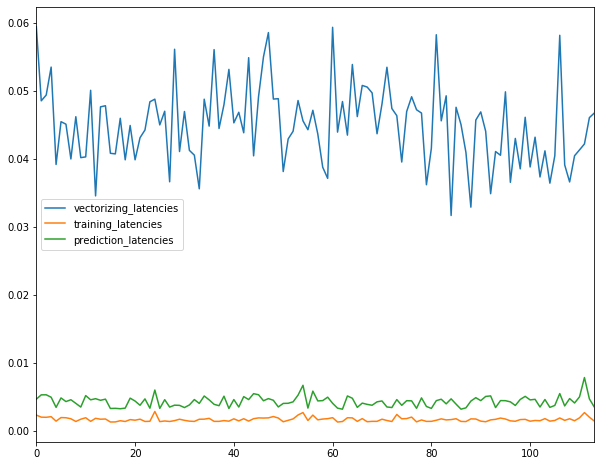

In [27]:
plot_latency_graphs(sgd_training_details_df)

In [28]:
def plot_accuracy_graphs(training_details_df):
    
    training_details_df[['prediction_accuracies']].plot(figsize=(10, 8))
    
    plt.show()

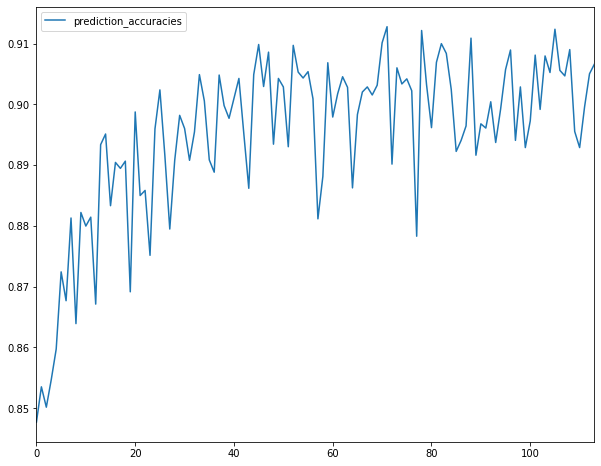

In [29]:
plot_accuracy_graphs(sgd_training_details_df)

#### Test it on the test data

In [30]:
y_pred = sgd_training_details['classifier'].predict(x_test)

In [31]:
accuracy_score(y_test, y_pred)

0.9037911052153879

In [32]:
precision_score(y_test, y_pred)

0.8934426229508197

In [33]:
recall_score(y_test, y_pred)

0.43755575379125783

In [34]:
np.bincount(y_pred)

array([13225,  1098])

### Evaluate the other classifiers which support out-of-core learning

In [52]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB

In [53]:
partial_fit_clfs = {'SGD': SGDClassifier(), 
                    'PassiveAggressive': PassiveAggressiveClassifier(), 
                    'Perceptron': Perceptron(),
                    'BernoulliNB': BernoulliNB()}

SGD
****************************************


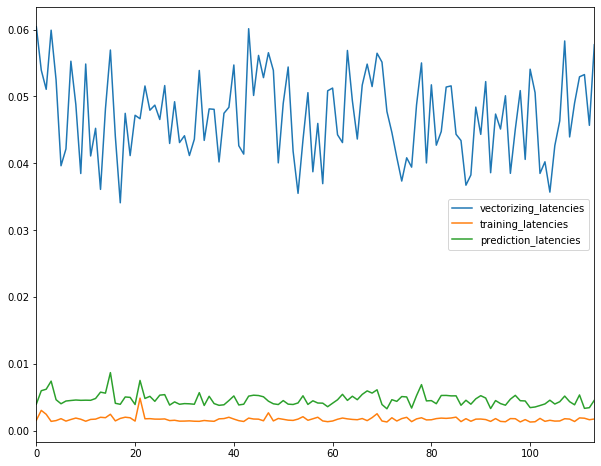

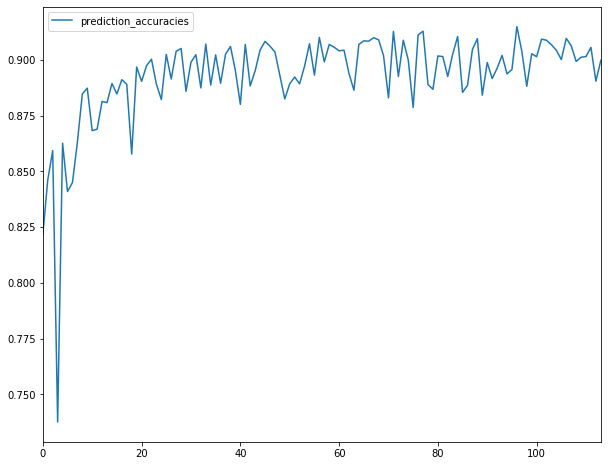

****************************************
PassiveAggressive
****************************************


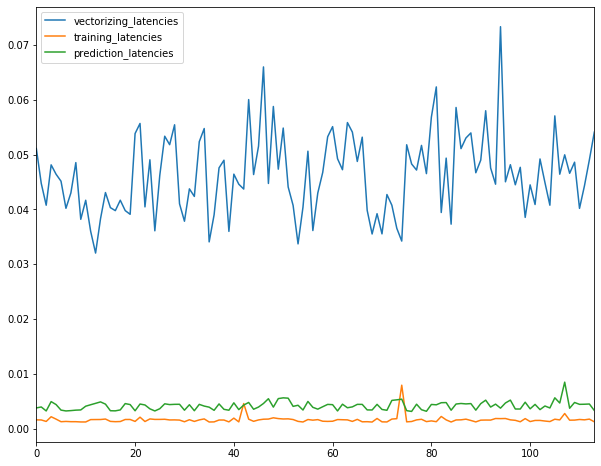

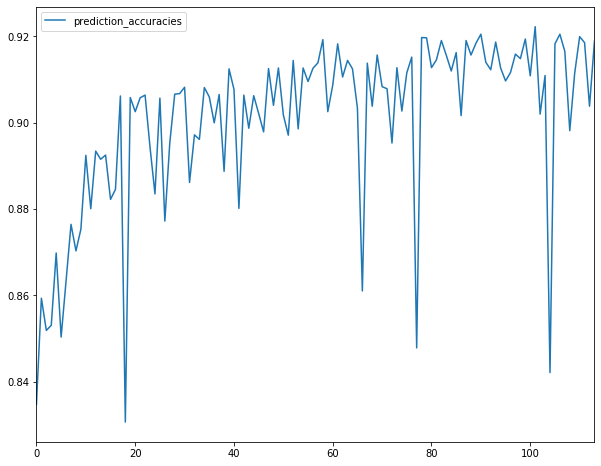

****************************************
Perceptron
****************************************


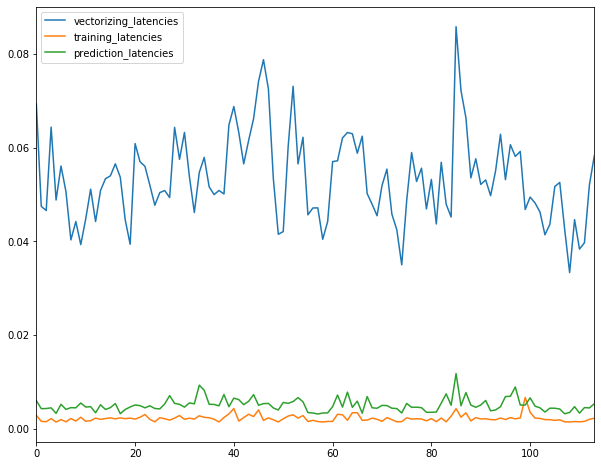

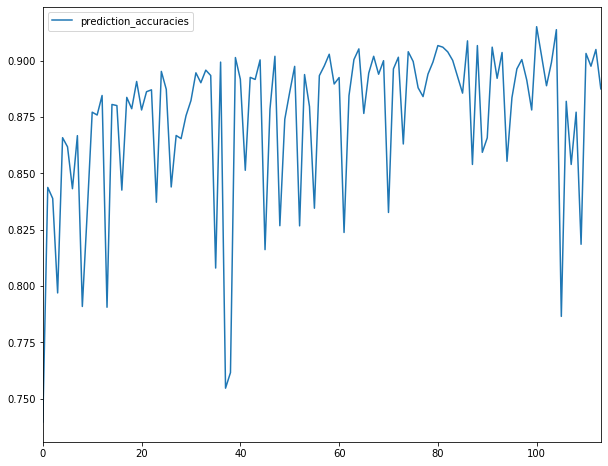

****************************************
BernoulliNB
****************************************


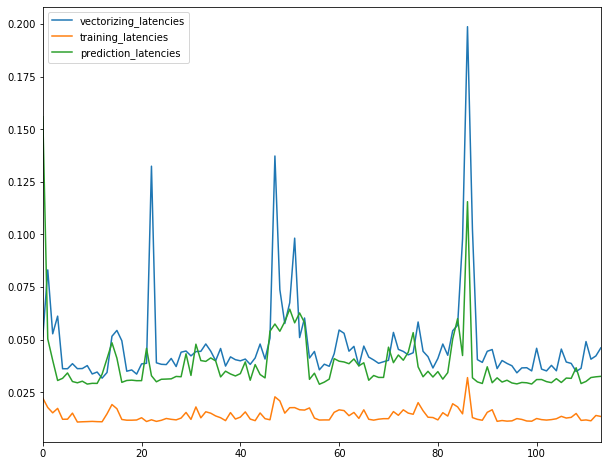

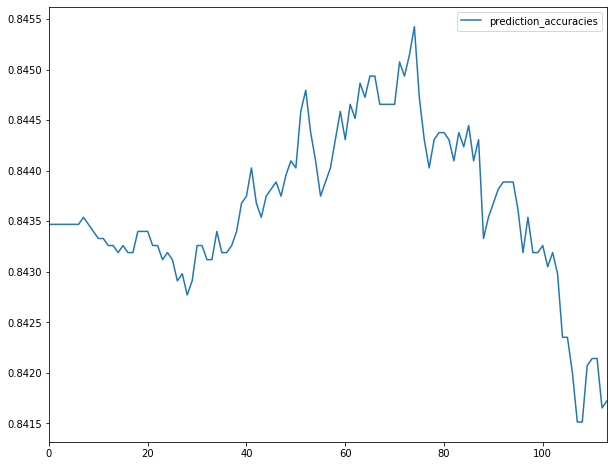

****************************************


In [54]:
for clf_name, clf in partial_fit_clfs.items():

    print(clf_name)
    print('****' * 10)
    
    training_details = train_classifier(clf, 
                                        x_train, 
                                        y_train, 
                                        batch_size, 
                                        classes)

    training_details_df = convert_to_dataframe(training_details)
    
    plot_latency_graphs(training_details_df)
    
    plot_accuracy_graphs(training_details_df)
    
    print('****' * 10)
    sys.stdout.flush()

In [55]:
clf_stats = {}
for clf_name in partial_fit_clfs:
    
    stats = {'accuracy': 0.0, 
             'precision': 0.0,
             'recall' : 0.0}
    
    clf_stats[clf_name] = stats

clf_stats

{'BernoulliNB': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'PassiveAggressive': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'Perceptron': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'SGD': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}}

In [56]:
for clf_name, clf in partial_fit_clfs.items():
    
    y_pred = clf.predict(x_test)
    
    clf_stats[clf_name]['accuracy'] = accuracy_score(y_test, y_pred)
    clf_stats[clf_name]['precision'] = precision_score(y_test, y_pred)
    clf_stats[clf_name]['recall'] = recall_score(y_test, y_pred)
    

In [57]:
import pprint 

pprint.pprint(clf_stats)

{'BernoulliNB': {'accuracy': 0.8416532849263423,
                 'precision': 0.48640167364016734,
                 'recall': 0.20740410347903657},
 'PassiveAggressive': {'accuracy': 0.9202681002583257,
                       'precision': 0.7513711151736746,
                       'recall': 0.7332738626226584},
 'Perceptron': {'accuracy': 0.9144732248830553,
                'precision': 0.785513756316676,
                'recall': 0.6239964317573595},
 'SGD': {'accuracy': 0.9099350694686867,
         'precision': 0.8515509601181684,
         'recall': 0.5142729705619982}}
